In [ ]:

import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
from skimage.transform import resize


%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#Transfer 'png' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname))/255
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = resize(img, (RESIZE,RESIZE,3))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/ddsm/Benign/original/CC_Benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/ddsm/Cancer/original',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/Minita/image_val',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/stage1_test/images',224))

 72%|███████▏  | 75/104 [03:06<01:12,  2.49s/it]

In [ ]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

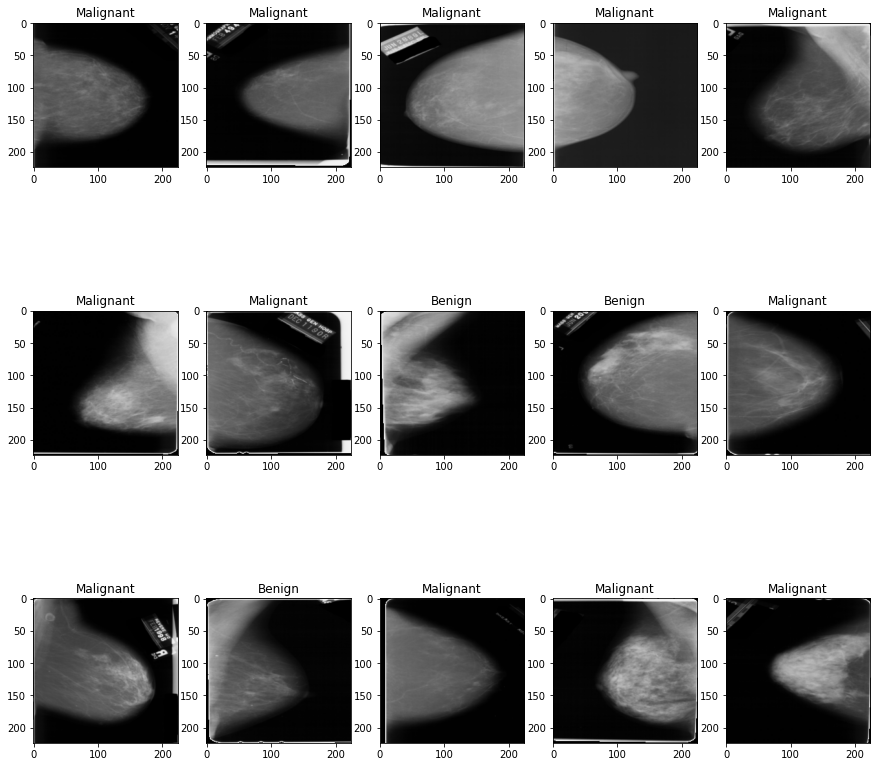

In [ ]:
# # Display first 15 mammograms, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow((x_train[i]).astype(np.uint8))
plt.show()





Malignant


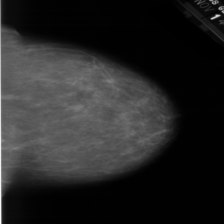

Malignant


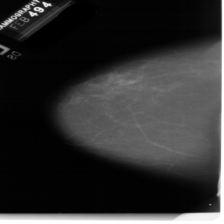

Malignant


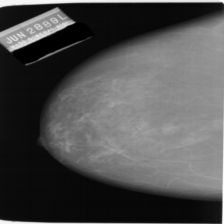

Malignant


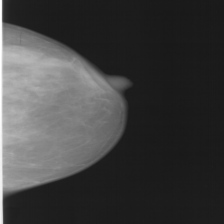

Malignant


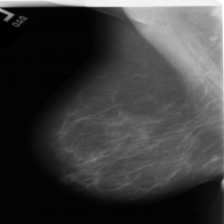

Malignant


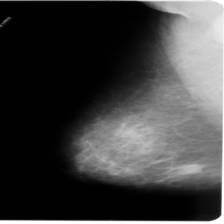

Malignant


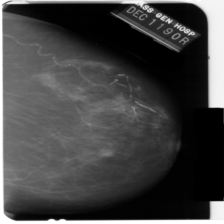

Benign


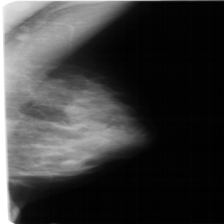

Benign


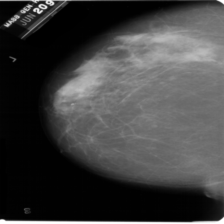

Malignant


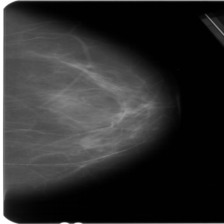

Malignant


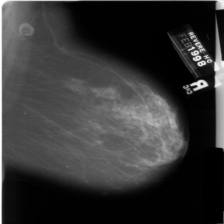

Benign


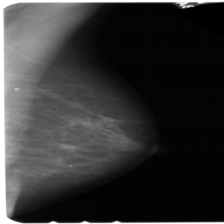

Malignant


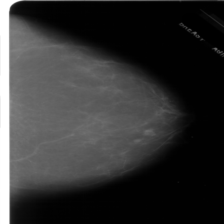

Malignant


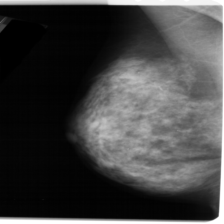

Malignant


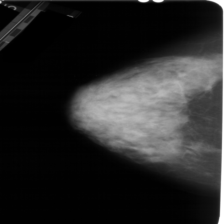

In [ ]:

from google.colab.patches import cv2_imshow
for i in range(1, columns*rows +1):
  if np.argmax(Y_train[i]) == 0:
    print("Benign")
  else:
    print("Malignant")

  cv2_imshow(x_train[i])


In [ ]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [ ]:
#callback = [EarlyStopping(monitor='loss', patience=0, verbose=1)]

model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(layers.Dropout(0.5))

model.add(Dense(4096, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

In [ ]:
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/MyDrive/Minita/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

In [ ]:
print(x_train.shape)
print(y_train.shape)


(243, 224, 224, 3)
(243, 2)


In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
15/15 [==============================] - 43s 1s/step - loss: 0.7639 - accuracy: 0.5435 - val_loss: 0.5954 - val_accuracy: 0.7213

Epoch 00001: val_loss improved from -inf to 0.59540, saving model to /content/drive/MyDrive/Minita/weights.best.hdf5
Epoch 2/20
15/15 [==============================] - 10s 673ms/step - loss: 0.7679 - accuracy: 0.5377 - val_loss: 0.6421 - val_accuracy: 0.6721

Epoch 00002: val_loss improved from 0.59540 to 0.64211, saving model to /content/drive/MyDrive/Minita/weights.best.hdf5
Epoch 3/20
15/15 [==============================] - 10s 676ms/step - loss: 0.7123 - accuracy: 0.5975 - val_loss: 0.6649 - val_accuracy: 0.5574

Epoch 00003: val_loss improved from 0.64211 to 0.66489, saving model to /content/drive/MyDrive/Minita/weights.best.hdf5
Epoch 4/20
15/15 [==============================] - 11s 676ms/step - loss: 0.7318 - accuracy: 0.5712 - val_loss: 0.6189 - val_accuracy: 0.6885

Epoch 00004: val_loss did not improve from 0.66489
Epoch 5/20
15/15 [=

In [ ]:
model.load_weights("/content/drive/MyDrive/Minita/weights.best.hdf5")
Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))
Y_pred = model.predict(X_test)


In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '

100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


Confusion matrix, without normalization
[[92 24]
 [34 16]]


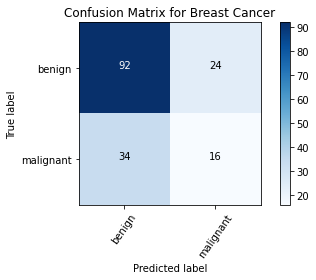

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Breast Cancer')

In [ ]:
#Classification Report
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.71      0.64      0.67       116\n           1       0.32      0.40      0.36        50\n\n    accuracy                           0.57       166\n   macro avg       0.52      0.52      0.51       166\nweighted avg       0.59      0.57      0.58       166\n'

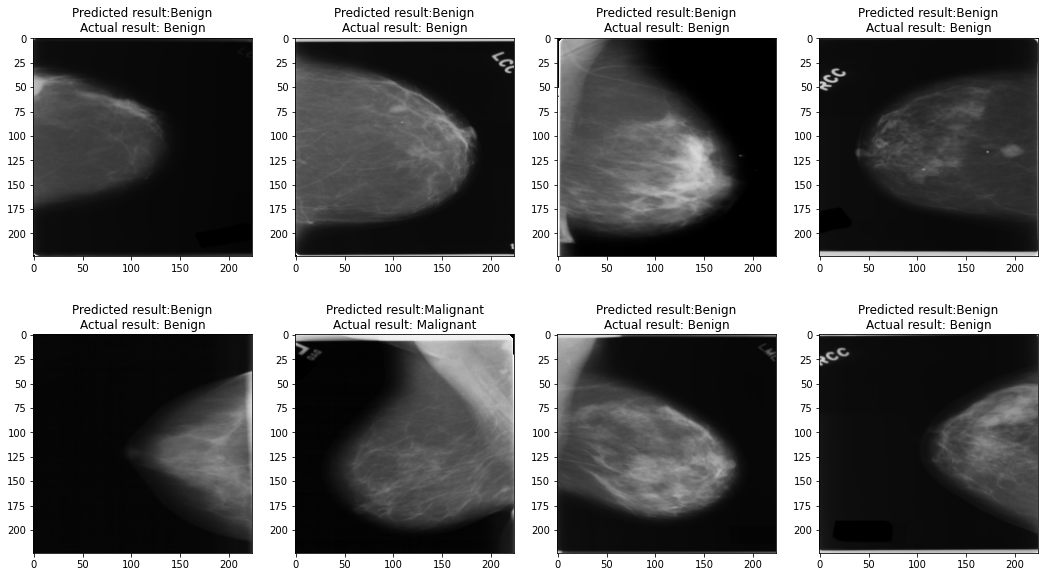

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==10):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow((X_test[prop_class[i]]).astype(np.uint8))
plt.show()

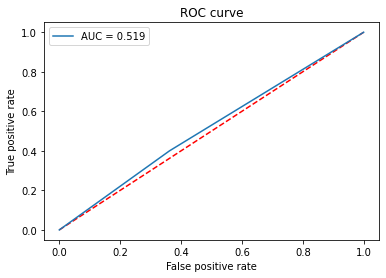

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()